In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
from sklearn.model_selection import train_test_split

In [2]:
#import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bioresponce = pd.read_csv('/content/drive/My Drive/Datasets/bioresponse.csv', header=0, sep = ",")
bioresponce_target = bioresponce.Activity.values
bioresponce_data = bioresponce.iloc[:,1:]
x_train, x_test, y_train, y_test = train_test_split(bioresponce_data, bioresponce_target, test_size = 0.25, random_state = 1)
x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

In [4]:
x_train.info

<bound method DataFrame.info of            855       784       825   ...      1096      235       1061
D1     0.000000  0.033300  0.066700  ...  0.000000  0.066700  0.466667
D2     0.504332  0.655264  0.623502  ...  0.502836  0.595049  0.624108
D3     0.150000  0.050000  0.050000  ...  0.000000  0.150000  0.100000
D4     0.000000  0.000000  0.000000  ...  0.000000  0.250000  0.000000
D5     0.106456  0.231493  0.242355  ...  0.254729  0.176495  0.083200
...         ...       ...       ...  ...       ...       ...       ...
D1772  0.000000  0.000000  0.000000  ...  0.000000  0.000000  1.000000
D1773  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
D1774  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
D1775  0.000000  0.000000  0.000000  ...  0.000000  0.000000  1.000000
D1776  0.000000  0.000000  0.000000  ...  0.000000  1.000000  0.000000

[1776 rows x 2813 columns]>

In [6]:
def sigmoid(z):
    return 1./(1.+np.exp(-z))

def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.
    return w, b

def propagate(w, b, X, Y):
    m = X.shape[1]
    # compute activation
    A = sigmoid(np.dot(w.T,X)+b )   
    
    # compute cost                             
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction

In [75]:
def optimize_GD(X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    num_iteration = []
    w, b = initialize_with_zeros(x_train.shape[0])
    for i in range(num_iterations):
        
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(float(cost))
            num_iteration.append(i)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs, num_iteration

def optimize_SGD(X, Y, num_iterations, minibatch_size, learning_rate, print_cost = False):
    costs = []
    num_iteration = []
    w, b = initialize_with_zeros(x_train.shape[0])
    for i in range(num_iterations):
        X1, _, Y1, _ = train_test_split(X.T, Y, train_size = minibatch_size, random_state = random.randrange(100))      
        X1 = X1.T
        
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X1,Y1)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(float(cost))
            num_iteration.append(i)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs, num_iteration

def optimizer_adam(X, Y, num_iterations, step_size = 0.00005, beta1 = 0.9, beta2 = 0.999, print_cost = False):
    print("Choosen optimizer: ADAM")
    w, b = initialize_with_zeros(x_train.shape[0])
    costs = []
    num_iteration = []
    epsilon = 0.0001
    m_w = np.zeros(w.shape[1])       
    v_w = np.zeros(w.shape[1])      
    m_b = 0       
    v_b = 0

    w_next = w
    b_next = b

    for i in range(num_iterations):
      #remember vector from previous iteration
      w = w_next
      b = b_next

      # Cost and gradient calculation 
      grads, cost = propagate(w, b, X, Y)
    
      # Retrieve derivatives from grads
      dw = grads["dw"]
      db = grads["db"]
      
      #update moment vectors
      v_w = beta2 * v_w + (1 - beta2)*np.square(dw)
      m_w = beta1 * m_w  + (1 - beta1)*(dw)
      v_b = beta2 * v_b + (1 - beta2)*np.square(db)
      m_b = beta1 * m_b  + (1 - beta1)*(db)
    
      #compute bias correction vectors 
      v_est_w = v_w / (1 - pow(beta1, i+1))
      m_est_w = m_w / (1 - pow(beta2, i+1))
      v_est_b = v_b / (1 - pow(beta1, i+1))
      m_est_b = m_b / (1 - pow(beta2, i+1))
      
      w_next = np.subtract(w, (step_size*m_est_w / (np.sqrt(v_est_w) + epsilon)))
      b_next = np.subtract(b, (step_size*m_est_b / (np.sqrt(v_est_b) + epsilon)))
      
      # Record the costs
      if i % 100 == 0:
          costs.append(float(cost))
          num_iteration.append(i)
      
      if print_cost and i % 100 == 0:
          print ("Cost after iteration %i: %f" %(i, cost)) 
    params = {"w": w_next,
              "b": b_next}

    return params, costs, num_iteration

In [49]:
def model(X_train, Y_train, X_test, Y_test, optimizer = "GD", num_iterations = 2000, minibatch_size = 0.2, learning_rate = 0.2, print_cost = False, print_result = True):
    
    # Gradient descent
    if optimizer == "GD":
      parameters, grads, costs, num_iteration = optimize_GD(X_train, Y_train, num_iterations, learning_rate, print_cost)
    elif optimizer == "SGD":
      parameters, grads, costs, num_iteration = optimize_SGD(X_train, Y_train, num_iterations, minibatch_size, learning_rate, print_cost)
    elif optimizer == "ADAM":
      parameters, costs, num_iteration = optimizer_adam(X_train, Y_train, num_iterations, print_cost=print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    if print_result == True:
      if optimizer != "ADAM":
        print("Learn rate: {0:.3f}".format(learning_rate))
      print("train accuracy: {0:.3} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
      print("test accuracy: {0:.3f} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iteration}
    
    return d

###get plot for SGD with different learning rate

Learn rate: 0.001
train accuracy: 55.3 %
test accuracy: 57.569 %
Learn rate: 0.050
train accuracy: 77.2 %
test accuracy: 74.627 %
Learn rate: 0.100
train accuracy: 79.0 %
test accuracy: 76.226 %
Learn rate: 0.200
train accuracy: 80.9 %
test accuracy: 77.292 %
Learn rate: 0.300
train accuracy: 75.9 %
test accuracy: 72.388 %


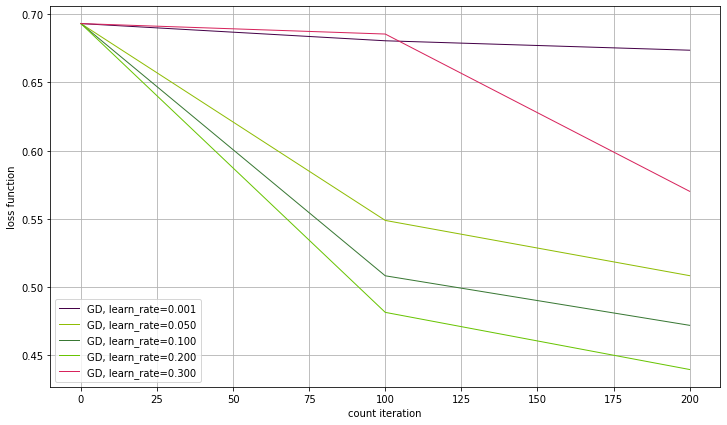

In [84]:
learn_rate_list = [0.001, 0.05, 0.1, 0.2, 0.3]
value_loss_function_list = []
for i in range(len(learn_rate_list)):
  learn_rate = learn_rate_list[i]
  gd_output = model(x_train, y_train, x_test, y_test, num_iterations = 1001, learning_rate=learn_rate, print_cost = False, print_result = True)
  value_loss_function_list.append(gd_output['costs'])
get_plot(gd_output['num_iterations'], value_loss_function_list, learn_rate_list, "GD")

###get plot for SGD with different learning rate

Learn rate: 0.001
train accuracy: 54.9 %
test accuracy: 56.503 %
Learn rate: 0.050
train accuracy: 77.6 %
test accuracy: 74.414 %
Learn rate: 0.100
train accuracy: 78.6 %
test accuracy: 76.333 %
Learn rate: 0.200
train accuracy: 80.2 %
test accuracy: 76.972 %
Learn rate: 0.300
train accuracy: 74.3 %
test accuracy: 71.215 %


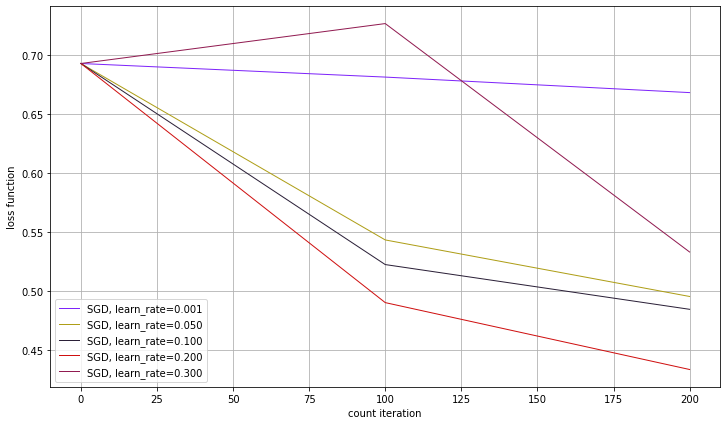

In [85]:
learn_rate_list = [0.001, 0.05, 0.1, 0.2, 0.3]
value_loss_function_list = []
for i in range(len(learn_rate_list)):
  learn_rate = learn_rate_list[i]
  sgd_output = model(x_train, y_train, x_test, y_test, optimizer = "SGD", num_iterations = 1001, learning_rate=learn_rate, print_cost = False, print_result = True)
  value_loss_function_list.append(sgd_output['costs'])
get_plot(sgd_output['num_iterations'], value_loss_function_list, learn_rate_list, 'SGD')

###ADAM

In [82]:
def get_plot(count_iteration, value_loss_function, learning_rate, name_method):
  plt.figure(figsize=(12,7)) 
  plt.xlabel('count iteration') 
  plt.ylabel('loss function') 
  for i in range(len(value_loss_function)):
    rgb = np.random.rand(3,)
    plt.plot(count_iteration, value_loss_function[i], linewidth = 1, label = "{0}, learn_rate={1:.3f}".format(name_method, learning_rate[i]), color=rgb) #drew approx function
  plt.grid(True)
  plt.legend(loc='lower left') 
  plt.show() 

Choosen optimizer: ADAM
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.445665
Cost after iteration 200: 0.433229
Cost after iteration 300: 0.426865
Cost after iteration 400: 0.422515
Cost after iteration 500: 0.419157
Cost after iteration 600: 0.416380
Cost after iteration 700: 0.413982
Cost after iteration 800: 0.411846
Cost after iteration 900: 0.409901
Cost after iteration 1000: 0.408101
train accuracy: 82.7 %
test accuracy: 75.373 %


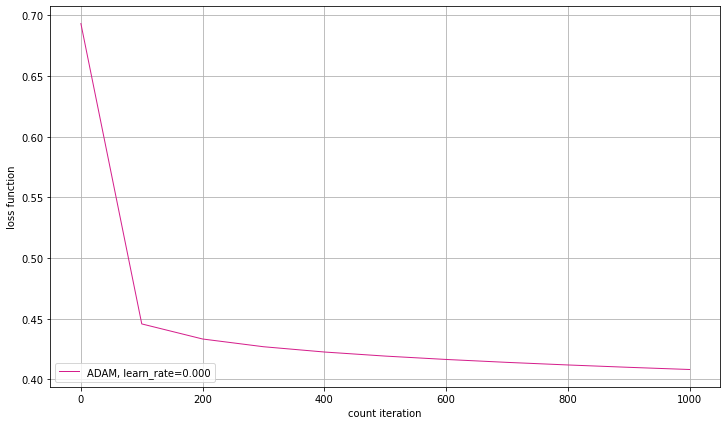

In [96]:
adam_output = model(x_train, y_train, x_test, y_test, num_iterations = 1001, optimizer="ADAM",print_cost = True, print_result = True)
learn_rate_list = [0.0001]
value_loss_function_list = []
value_loss_function_list.append(adam_output['costs'])
get_plot(adam_output['num_iterations'], value_loss_function_list, learn_rate_list, 'ADAM')